In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from scipy.spatial import cKDTree

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down

In [2]:
yy_s, yy_e = 2002, 2023
years_num = yy_e - yy_s + 1

npix = 2
acf = 'mar'
cor = 'pearson'

lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

In [3]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')

In [5]:
Tr = [5,  10,  20,  50, 100, 200]

In [6]:
# CMORPH data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_CM = xr.open_dataset(data_dir)
time_year = DATA_CM.year.values
del DATA_CM

In [7]:
def get_nearest_values(ref_lat2d, ref_lon2d, target_lat2d, target_lon2d, target_data):
    """
    Para cada punto en la malla de referencia, busca el valor más cercano en la malla objetivo.
    """
    ny, nx = ref_lat2d.shape
    ref_points = np.column_stack((ref_lat2d.ravel(), ref_lon2d.ravel()))
    target_points = np.column_stack((target_lat2d.ravel(), target_lon2d.ravel()))
    tree = cKDTree(target_points)
    _, idx = tree.query(ref_points)
    matched_values = target_data.ravel()[idx]
    return matched_values.reshape(ny, nx)

In [8]:
def Create_Ensemble(REFERENCE, SATELLITES, PARAM):

    data_dir = os.path.join(dir_base, f'ITALY_DOWN_{REFERENCE}_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
    DATA_REF = xr.open_dataset(data_dir)
    lons_REF, lats_REF = DATA_REF.lon.values, DATA_REF.lat.values
    lon2d_REF, lat2d_REF = np.meshgrid(lons_REF, lats_REF)

    data_dir = os.path.join(dir_base, f'ITALY_DOWN_{SATELLITES[0]}_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
    DATA_SAT1 = xr.open_dataset(data_dir)
    lon2d_SAT1, lat2d_SAT1 = np.meshgrid(DATA_SAT1.lon.values, DATA_SAT1.lat.values)

    data_dir = os.path.join(dir_base, f'ITALY_DOWN_{SATELLITES[1]}_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
    DATA_SAT2 = xr.open_dataset(data_dir)
    lon2d_SAT2, lat2d_SAT2 = np.meshgrid(DATA_SAT2.lon.values, DATA_SAT2.lat.values)

    # data_dir = os.path.join(dir_base, f'ITALY_DOWN_{SATELLITES[2]}_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
    data_dir = os.path.join(dir_base, f'ITALY_DOWN_{SATELLITES[2]}_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_NoCorrection.nc')
    DATA_SAT3 = xr.open_dataset(data_dir)
    lon2d_SAT3, lat2d_SAT3 = np.meshgrid(DATA_SAT3.lon.values, DATA_SAT3.lat.values)

    data_dir = os.path.join(dir_base, f'ITALY_DOWN_{SATELLITES[3]}_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
    DATA_SAT4 = xr.open_dataset(data_dir)
    lon2d_SAT4, lat2d_SAT4 = np.meshgrid(DATA_SAT4.lon.values, DATA_SAT4.lat.values)

    data_dir = os.path.join(dir_base, f'ITALY_DOWN_{SATELLITES[4]}_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
    DATA_SAT5 = xr.open_dataset(data_dir)
    lon2d_SAT5, lat2d_SAT5 = np.meshgrid(DATA_SAT5.lon.values, DATA_SAT5.lat.values)

    # ==================================================================================================

    ntimes = DATA_REF[PARAM].shape[0]  # número de tiempos

    REF_remap = np.full((ntimes, *lat2d_REF.shape), np.nan)

    REFE_remap = np.full_like(REF_remap, np.nan)
    SAT1_remap = np.full_like(REF_remap, np.nan)
    SAT2_remap = np.full_like(REF_remap, np.nan)
    SAT3_remap = np.full_like(REF_remap, np.nan)
    SAT4_remap = np.full_like(REF_remap, np.nan)
    SAT5_remap = np.full_like(REF_remap, np.nan)

    for i in range(ntimes):
        REFE = DATA_REF[PARAM].values[i, :, :]
        SAT1 = DATA_SAT1[PARAM].values[i, :, :]    
        SAT2 = DATA_SAT2[PARAM].values[i, :, :]
        SAT3 = DATA_SAT3[PARAM].values[i, :, :]
        SAT4 = DATA_SAT4[PARAM].values[i, :, :]
        SAT5 = DATA_SAT5[PARAM].values[i, :, :]

        SAT1_near = get_nearest_values(lat2d_REF, lon2d_REF, lat2d_SAT1, lon2d_SAT1, SAT1)
        SAT2_near = get_nearest_values(lat2d_REF, lon2d_REF, lat2d_SAT2, lon2d_SAT2, SAT2)
        SAT3_near = get_nearest_values(lat2d_REF, lon2d_REF, lat2d_SAT3, lon2d_SAT3, SAT3)
        SAT4_near = get_nearest_values(lat2d_REF, lon2d_REF, lat2d_SAT4, lon2d_SAT4, SAT4)
        SAT5_near = get_nearest_values(lat2d_REF, lon2d_REF, lat2d_SAT5, lon2d_SAT5, SAT5)

        REFE_remap[i, :, :] = REFE
        SAT1_remap[i, :, :] = SAT1_near
        SAT2_remap[i, :, :] = SAT2_near
        SAT3_remap[i, :, :] = SAT3_near
        SAT4_remap[i, :, :] = SAT4_near
        SAT5_remap[i, :, :] = SAT5_near

    stacked_all = np.stack([REFE_remap, SAT1_remap, SAT2_remap, SAT3_remap, SAT4_remap, SAT5_remap], axis=0)
    Ensemble_mean   = np.nanmean(stacked_all, axis=0)
    Ensemble_median = np.nanmedian(stacked_all, axis=0)

    # Ensemble WEIGHTED
    p = stacked_all.shape[0]
    # 1) median reference (por tiempo o agregado) -> aquí por tiempo
    median = np.nanmedian(stacked_all, axis=0)
    # 2) compute mean absolute dev from median per product (avg over time)
    mad = np.nanmean(np.abs(stacked_all - median), axis=1)  # (p, ny, nx)
    # 3) inverse mad weights (higher weight = closer to median)
    inv_mad = 1.0 / (mad + 1e-6)
    w = inv_mad / np.nansum(inv_mad, axis=0)  # (p, ny, nx)
    # 4) weighted ensemble per time
    Ensemble_weighted = np.nansum(w[:, None, :, :] * stacked_all, axis=0)  # (nt, ny, nx)

    # Ensemble TRIMEAN
    Q25 = np.nanpercentile(stacked_all, 25, axis=0)
    Q50 = np.nanpercentile(stacked_all, 50, axis=0)
    Q75 = np.nanpercentile(stacked_all, 75, axis=0)
    Ensemble_trimean = (Q25 + 2*Q50 + Q75) / 4

    return Ensemble_mean, Ensemble_median, Ensemble_weighted, Ensemble_trimean, lons_REF, lats_REF

In [9]:
REFERENCE = 'CHIRPS'
SATELLITES = ['CMORPH', 'ERA5', 'GSMaP', 'MSWEP', 'IMERG']

In [10]:
NYs_mean, NYs_median, NYs_weighted, NYs_trimean, lons_REF, lats_REF = Create_Ensemble(REFERENCE, SATELLITES, 'NYs')
CYs_mean, CYs_median, CYs_weighted, CYs_trimean, _, _ = Create_Ensemble(REFERENCE, SATELLITES, 'CYs')
WYs_mean, WYs_median, WYs_weighted, WYs_trimean, _, _ = Create_Ensemble(REFERENCE, SATELLITES, 'WYs')

NYd_mean, NYd_median, NYd_weighted, NYd_trimean, _, _ = Create_Ensemble(REFERENCE, SATELLITES, 'NYd')
CYd_mean, CYd_median, CYd_weighted, CYd_trimean, _, _ = Create_Ensemble(REFERENCE, SATELLITES, 'CYd')
WYd_mean, WYd_median, WYd_weighted, WYd_trimean, _, _ = Create_Ensemble(REFERENCE, SATELLITES, 'WYd')

lon2d_REF, lat2d_REF = np.meshgrid(lons_REF, lats_REF)

In [11]:
# =======================================================
# Mean
ENSEMBLE_Mevs_mean = ART_down.pre_quantiles_array(
                        NYs_mean, 
                        CYs_mean, 
                        WYs_mean, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

ENSEMBLE_Mevd_mean = ART_down.pre_quantiles_array(
                        NYd_mean, 
                        CYd_mean, 
                        WYd_mean, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

# =======================================================
# Median
ENSEMBLE_Mevs_median = ART_down.pre_quantiles_array(
                        NYs_median, 
                        CYs_median, 
                        WYs_median, 
                        Tr, 
                        lats_REF, lons_REF, 
                        1)

ENSEMBLE_Mevd_median = ART_down.pre_quantiles_array(
                        NYd_median, 
                        CYd_median, 
                        WYd_median, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

# =======================================================
# Weighted
ENSEMBLE_Mevs_weighted = ART_down.pre_quantiles_array(
                        NYs_weighted, 
                        CYs_weighted, 
                        WYs_weighted, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

ENSEMBLE_Mevd_weighted = ART_down.pre_quantiles_array(
                        NYd_weighted, 
                        CYd_weighted, 
                        WYd_weighted, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

# =======================================================
# Trimean
ENSEMBLE_Mevs_trimean = ART_down.pre_quantiles_array(
                        NYs_trimean, 
                        CYs_trimean, 
                        WYs_trimean, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

ENSEMBLE_Mevd_trimean = ART_down.pre_quantiles_array(
                        NYd_trimean, 
                        CYd_trimean, 
                        WYd_trimean, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

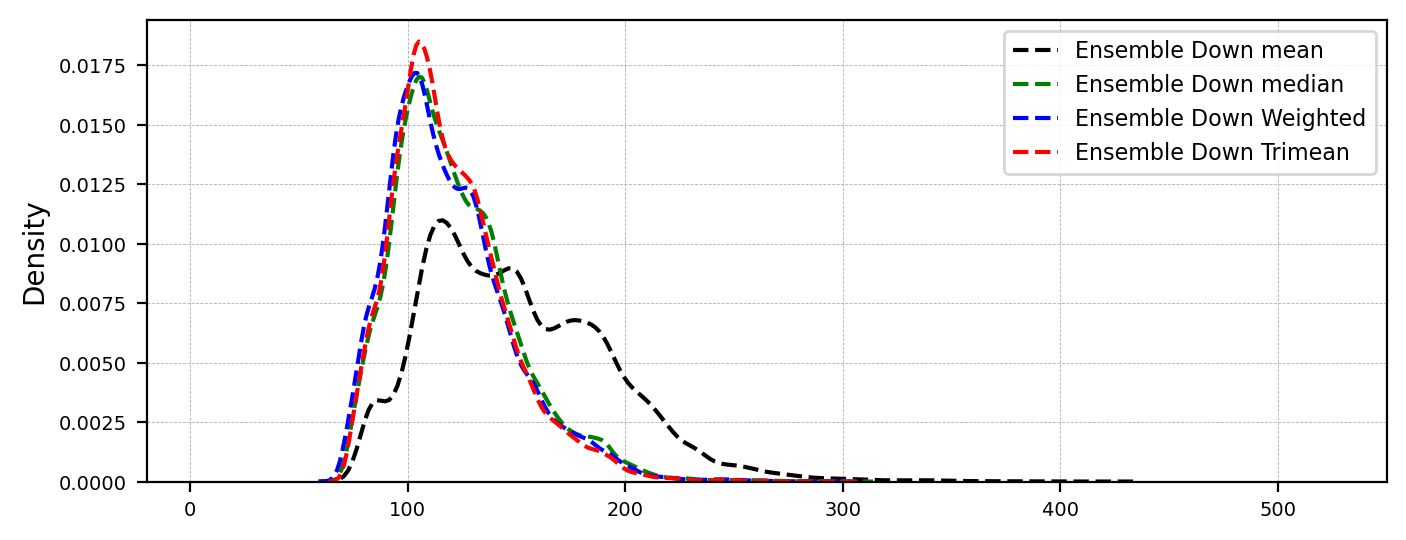

In [12]:
fig = plt.figure(figsize=(8,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

# sns.kdeplot(ENSEMBLE_Mevs_mean[3,:,:].flatten(),color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Sat mean')
sns.kdeplot(ENSEMBLE_Mevd_mean[3,:,:].flatten(),color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Down mean')

# sns.kdeplot(ENSEMBLE_Mevs_median[3,:,:].flatten(),color='g',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Sat median')
sns.kdeplot(ENSEMBLE_Mevd_median[3,:,:].flatten(),color='g',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Down median')

# sns.kdeplot(ENSEMBLE_Mevs_weighted[3,:,:].flatten(),color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Sat Weighted')
sns.kdeplot(ENSEMBLE_Mevd_weighted[3,:,:].flatten(),color='b',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Down Weighted')

# sns.kdeplot(ENSEMBLE_Mevs_trimean[3,:,:].flatten(),color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Sat Trimean')
sns.kdeplot(ENSEMBLE_Mevd_trimean[3,:,:].flatten(),color='r',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Down Trimean')

ax1.set_xlim(-20,550)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.legend(fontsize=8)

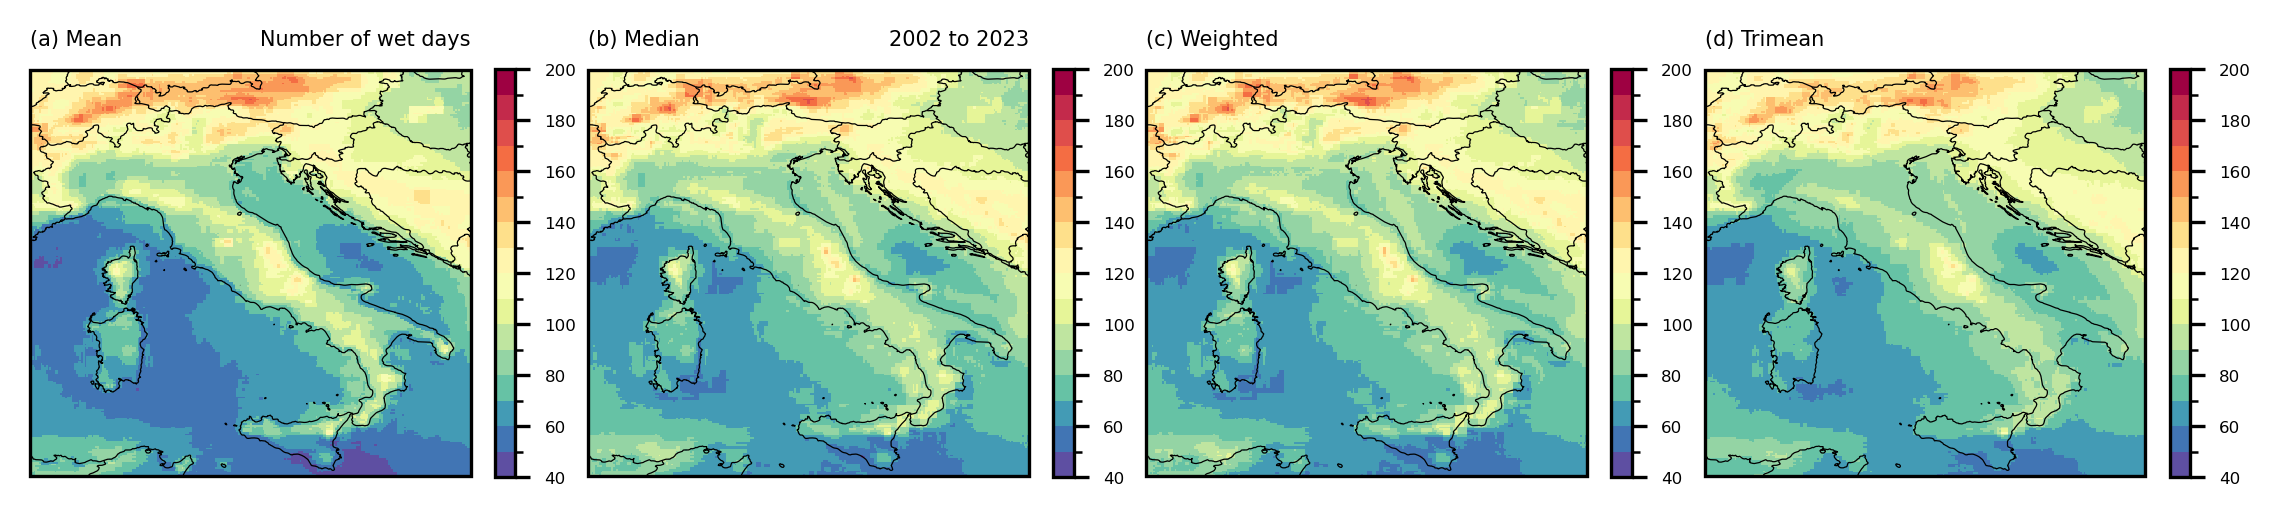

In [13]:
levels = np.arange(40, 210, 10)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
# norm = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,4)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(NYd_mean,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean', fontsize=5, loc='left')
ax1.set_title(f'Number of wet days', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(NYd_median,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Median', fontsize=5, loc='left')
ax1.set_title(f'{yy_s} to {yy_e}', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(NYd_weighted,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) Weighted', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 3], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(NYs_trimean,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(d) Trimean', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.15, hspace=0.15)

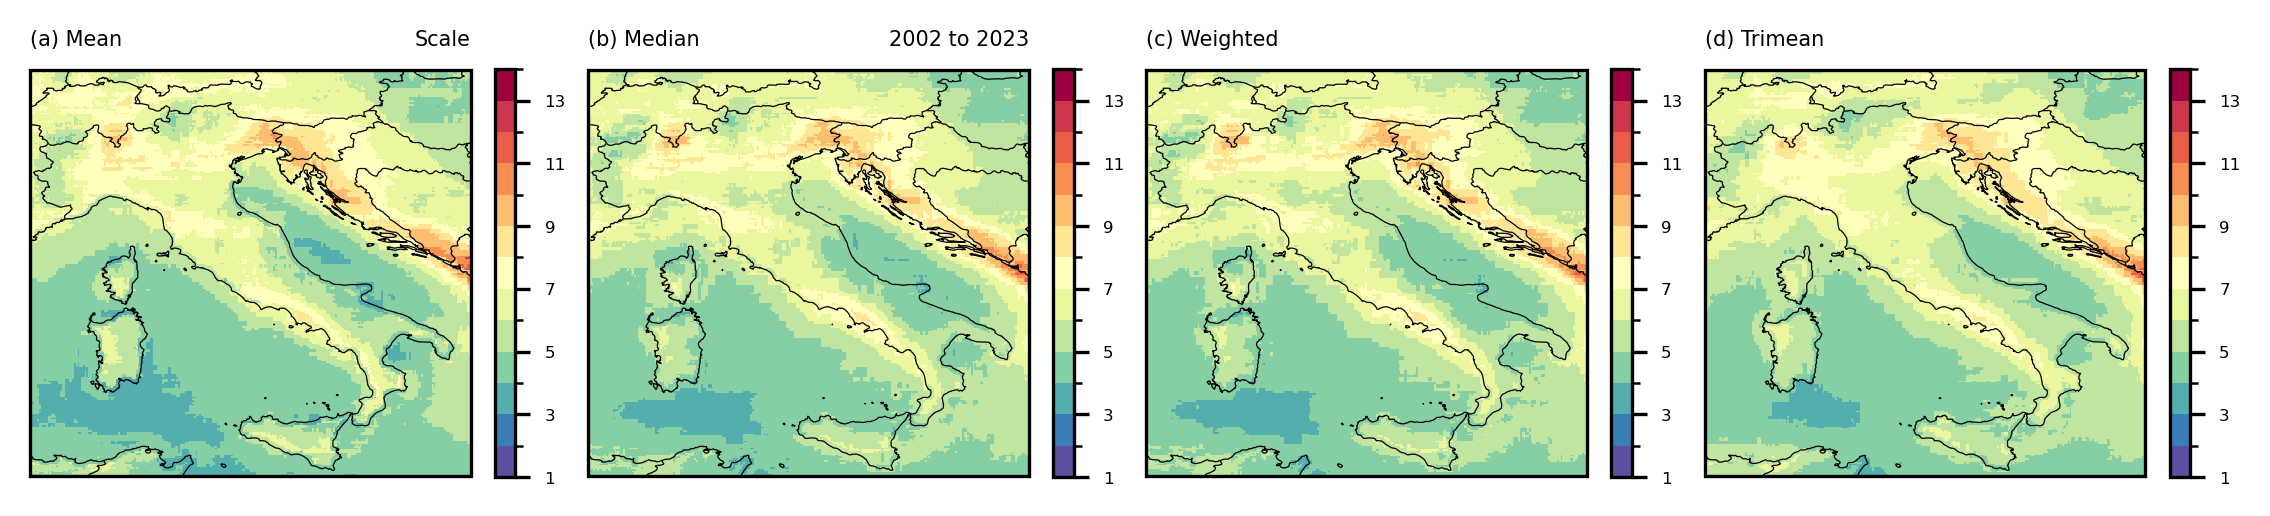

In [14]:
levels = np.arange(1, 15, 1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
# norm = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,4)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(CYd_mean,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean', fontsize=5, loc='left')
ax1.set_title(f'Scale', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(CYd_median,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Median', fontsize=5, loc='left')
ax1.set_title(f'{yy_s} to {yy_e}', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(CYd_weighted,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) Weighted', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 3], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(CYs_trimean,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(d) Trimean', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.15, hspace=0.15)

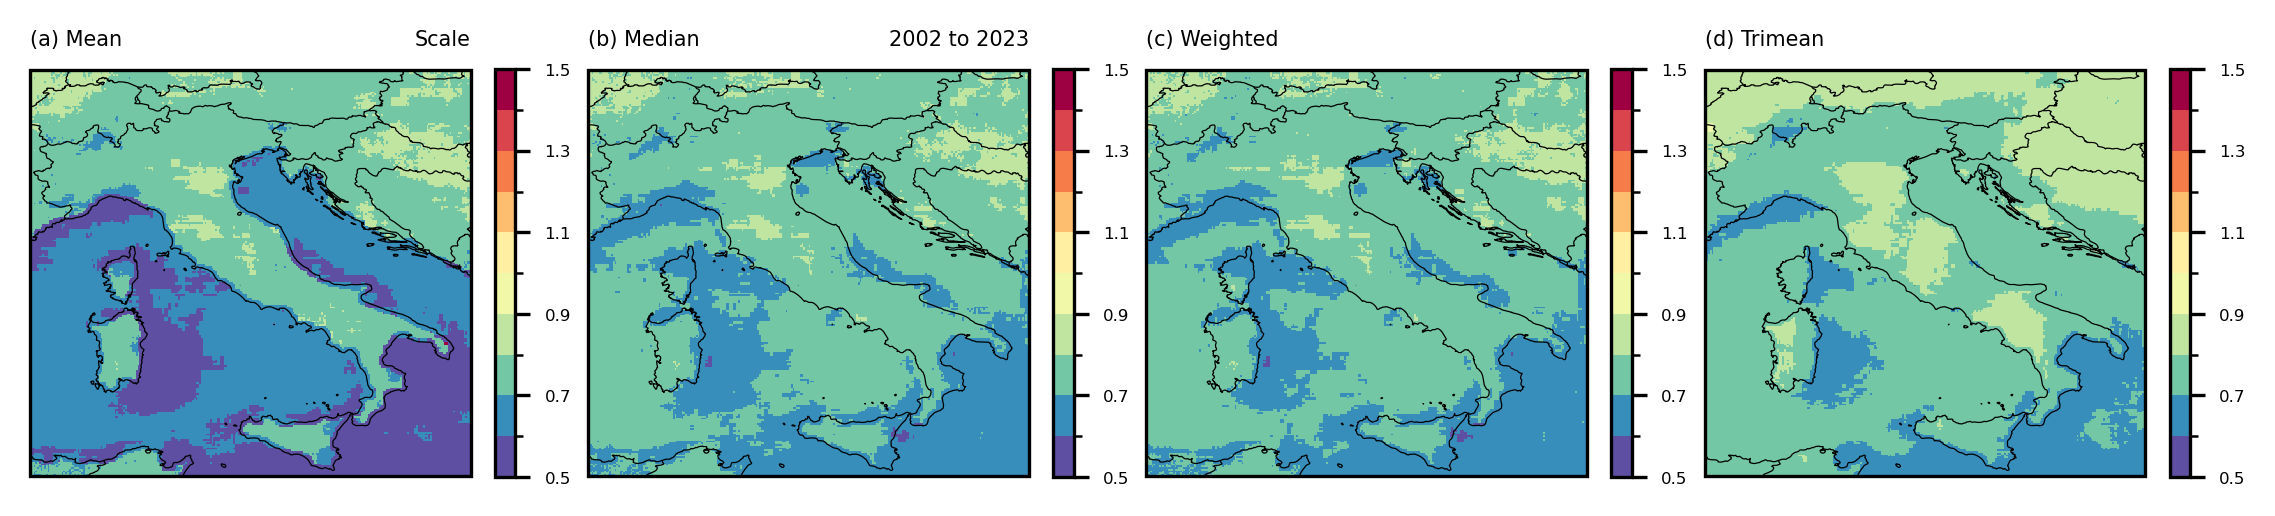

In [15]:
levels = np.arange(0.5, 1.6, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
# norm = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,4)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(WYd_mean,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean', fontsize=5, loc='left')
ax1.set_title(f'Scale', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(WYd_median,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Median', fontsize=5, loc='left')
ax1.set_title(f'{yy_s} to {yy_e}', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(WYd_weighted,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) Weighted', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 3], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, np.nanmean(WYs_trimean,axis=0), cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(d) Trimean', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.15, hspace=0.15)

In [16]:
ENSEMBLE_Mevd_mean.shape, WYd_weighted.shape

((6, 240, 260), (22, 240, 260))

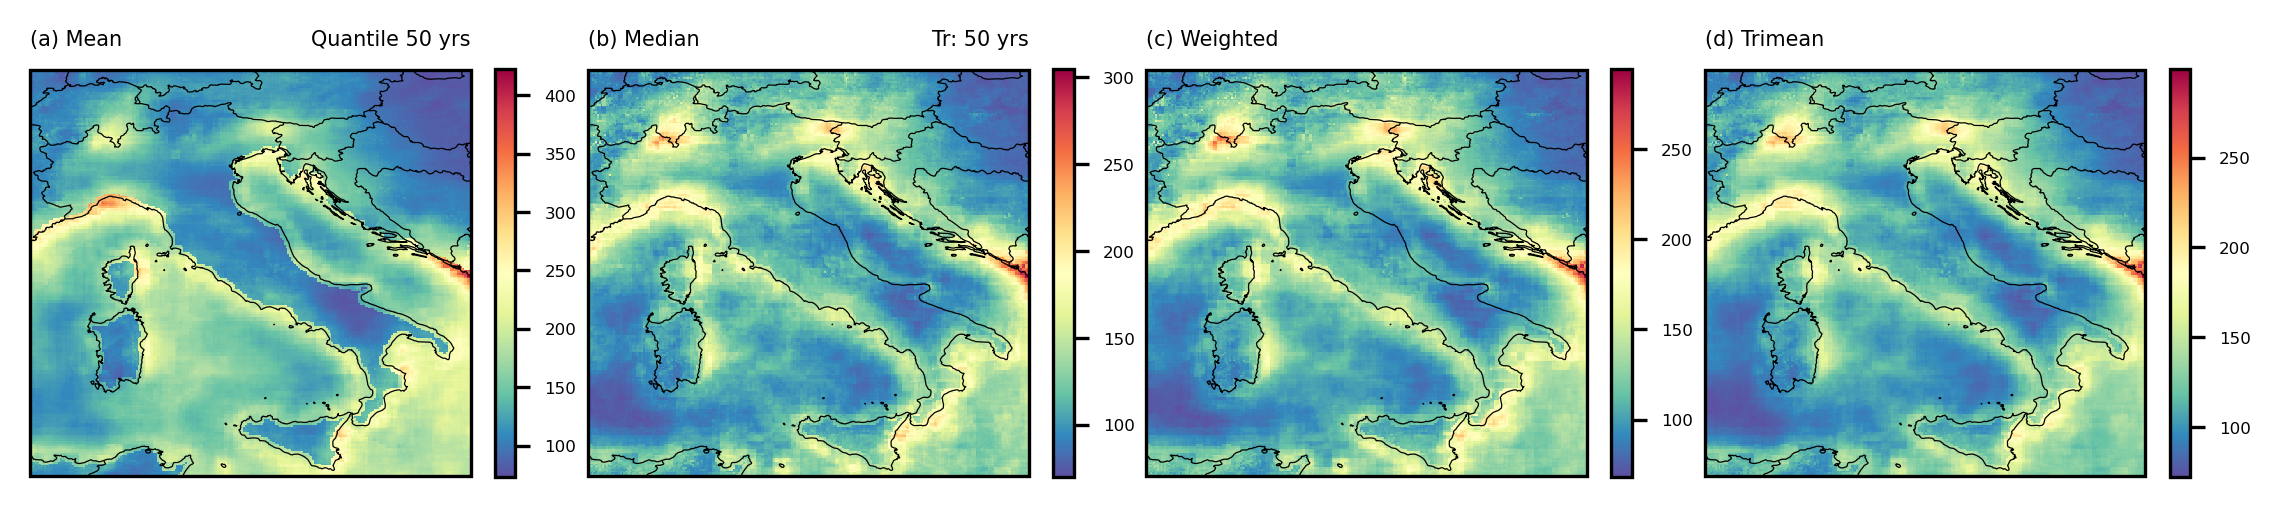

In [17]:
levels = np.arange(0.5, 1.6, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
norm = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,4)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevd_mean[3,:,:], cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean', fontsize=5, loc='left')
ax1.set_title(f'Quantile 50 yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevd_median[3,:,:], cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Median', fontsize=5, loc='left')
ax1.set_title(f'Tr: 50 yrs', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevd_weighted[3,:,:], cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) Weighted', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 3], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevd_trimean[3,:,:], cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(d) Trimean', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.15, hspace=0.15)

In [18]:
ENSEMBLE_xr = xr.Dataset(
    data_vars={
        "NYs": (("year","lat","lon"), NYs_mean),
        "CYs": (("year","lat","lon"), CYs_mean),
        "WYs": (("year","lat","lon"), WYs_mean),
        "NYd": (("year","lat","lon"), NYd_mean),
        "CYd": (("year","lat","lon"), CYd_mean),
        "WYd": (("year","lat","lon"), WYd_mean),
        "Mev_d": (("Tr","lat","lon"), ENSEMBLE_Mevd_mean),
        "Mev_s": (("Tr","lat","lon"), ENSEMBLE_Mevs_mean)
    },
    coords={
        'year': time_year, 
        'Tr': Tr, 
        'lat': lats_REF, 
        'lon': lons_REF
    },
    attrs=dict(description=f"ENSEMBLE-mean of the downscaled precipitation data for {yy_s}-{yy_e} period using CHIRPS grid using mean",)
)

ENSEMBLE_xr.NYs.attrs["units"] = "# days"
ENSEMBLE_xr.NYs.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYs.attrs["origname"] = "Sat Wet Days"

ENSEMBLE_xr.CYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYs.attrs["long_name"] = "Satellite Scale Parameter"
ENSEMBLE_xr.CYs.attrs["origname"] = "Sat Scale"

ENSEMBLE_xr.WYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYs.attrs["long_name"] = "Shape Parameter"
ENSEMBLE_xr.WYs.attrs["origname"] = "Sat Shape"

ENSEMBLE_xr.NYd.attrs["units"] = "# days"
ENSEMBLE_xr.NYd.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYd.attrs["origname"] = "Down Wet Days"

ENSEMBLE_xr.CYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYd.attrs["long_name"] = "Downscaling Scale Parameter"
ENSEMBLE_xr.CYd.attrs["origname"] = "Down Scale"

ENSEMBLE_xr.WYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYd.attrs["long_name"] = "Downscaling Shape Parameter"
ENSEMBLE_xr.WYd.attrs["origname"] = "Down Shape"

ENSEMBLE_xr.Mev_s.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_s.attrs["long_name"] = "Satellite Extreme Quantiles"
ENSEMBLE_xr.Mev_s.attrs["origname"] = "Sat Ext-Quant"

ENSEMBLE_xr.Mev_d.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_d.attrs["long_name"] = "Downscaling Extreme Quantiles"
ENSEMBLE_xr.Mev_d.attrs["origname"] = "Down Ext-Quant"

ENSEMBLE_xr.lat.attrs["units"] = "degrees_north"
ENSEMBLE_xr.lat.attrs["long_name"] = "Latitude"

ENSEMBLE_xr.lon.attrs["units"] = "degrees_east"
ENSEMBLE_xr.lon.attrs["long_name"] = "Longitude"

In [19]:
PRE_out = os.path.join(os.path.join(dir_base, f'ITALY_ENSEMBLE_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_mean_GSMaPNC.nc'))
print(f'Export PRE data to {PRE_out}')
ENSEMBLE_xr.to_netcdf(PRE_out)

Export PRE data to /media/arturo/T9/Data/Italy/Satellite/5_DOWN/ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_mean_GSMaPNC.nc


In [20]:
ENSEMBLE_xr = xr.Dataset(
    data_vars={
        "NYs": (("year","lat","lon"), NYs_median),
        "CYs": (("year","lat","lon"), CYs_median),
        "WYs": (("year","lat","lon"), WYs_median),
        "NYd": (("year","lat","lon"), NYd_median),
        "CYd": (("year","lat","lon"), CYd_median),
        "WYd": (("year","lat","lon"), WYd_median),
        "Mev_d": (("Tr","lat","lon"), ENSEMBLE_Mevd_median),
        "Mev_s": (("Tr","lat","lon"), ENSEMBLE_Mevs_median)
    },
    coords={
        'year': time_year, 
        'Tr': Tr, 
        'lat': lats_REF, 
        'lon': lons_REF
    },
    attrs=dict(description=f"ENSEMBLE of the downscaled precipitation data for {yy_s}-{yy_e} period using CHIRPS grid using median",)
)

ENSEMBLE_xr.NYs.attrs["units"] = "# days"
ENSEMBLE_xr.NYs.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYs.attrs["origname"] = "Sat Wet Days"

ENSEMBLE_xr.CYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYs.attrs["long_name"] = "Satellite Scale Parameter"
ENSEMBLE_xr.CYs.attrs["origname"] = "Sat Scale"

ENSEMBLE_xr.WYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYs.attrs["long_name"] = "Shape Parameter"
ENSEMBLE_xr.WYs.attrs["origname"] = "Sat Shape"

ENSEMBLE_xr.NYd.attrs["units"] = "# days"
ENSEMBLE_xr.NYd.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYd.attrs["origname"] = "Down Wet Days"

ENSEMBLE_xr.CYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYd.attrs["long_name"] = "Downscaling Scale Parameter"
ENSEMBLE_xr.CYd.attrs["origname"] = "Down Scale"

ENSEMBLE_xr.WYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYd.attrs["long_name"] = "Downscaling Shape Parameter"
ENSEMBLE_xr.WYd.attrs["origname"] = "Down Shape"

ENSEMBLE_xr.Mev_s.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_s.attrs["long_name"] = "Satellite Extreme Quantiles"
ENSEMBLE_xr.Mev_s.attrs["origname"] = "Sat Ext-Quant"

ENSEMBLE_xr.Mev_d.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_d.attrs["long_name"] = "Downscaling Extreme Quantiles"
ENSEMBLE_xr.Mev_d.attrs["origname"] = "Down Ext-Quant"

ENSEMBLE_xr.lat.attrs["units"] = "degrees_north"
ENSEMBLE_xr.lat.attrs["long_name"] = "Latitude"

ENSEMBLE_xr.lon.attrs["units"] = "degrees_east"
ENSEMBLE_xr.lon.attrs["long_name"] = "Longitude"

In [21]:
PRE_out = os.path.join(os.path.join(dir_base, f'ITALY_ENSEMBLE_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_median_GSMaPNC.nc'))
print(f'Export PRE data to {PRE_out}')
ENSEMBLE_xr.to_netcdf(PRE_out)

Export PRE data to /media/arturo/T9/Data/Italy/Satellite/5_DOWN/ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median_GSMaPNC.nc


In [22]:
ENSEMBLE_xr = xr.Dataset(
    data_vars={
        "NYs": (("year","lat","lon"), NYs_weighted),
        "CYs": (("year","lat","lon"), CYs_weighted),
        "WYs": (("year","lat","lon"), WYs_weighted),
        "NYd": (("year","lat","lon"), NYd_weighted),
        "CYd": (("year","lat","lon"), CYd_weighted),
        "WYd": (("year","lat","lon"), WYd_weighted),
        "Mev_d": (("Tr","lat","lon"), ENSEMBLE_Mevd_weighted),
        "Mev_s": (("Tr","lat","lon"), ENSEMBLE_Mevs_weighted)
    },
    coords={
        'year': time_year, 
        'Tr': Tr, 
        'lat': lats_REF, 
        'lon': lons_REF
    },
    attrs=dict(description=f"ENSEMBLE of the downscaled precipitation data for {yy_s}-{yy_e} period using CHIRPS grid using consensus-weighted",)
)

ENSEMBLE_xr.NYs.attrs["units"] = "# days"
ENSEMBLE_xr.NYs.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYs.attrs["origname"] = "Sat Wet Days"

ENSEMBLE_xr.CYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYs.attrs["long_name"] = "Satellite Scale Parameter"
ENSEMBLE_xr.CYs.attrs["origname"] = "Sat Scale"

ENSEMBLE_xr.WYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYs.attrs["long_name"] = "Shape Parameter"
ENSEMBLE_xr.WYs.attrs["origname"] = "Sat Shape"

ENSEMBLE_xr.NYd.attrs["units"] = "# days"
ENSEMBLE_xr.NYd.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYd.attrs["origname"] = "Down Wet Days"

ENSEMBLE_xr.CYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYd.attrs["long_name"] = "Downscaling Scale Parameter"
ENSEMBLE_xr.CYd.attrs["origname"] = "Down Scale"

ENSEMBLE_xr.WYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYd.attrs["long_name"] = "Downscaling Shape Parameter"
ENSEMBLE_xr.WYd.attrs["origname"] = "Down Shape"

ENSEMBLE_xr.Mev_s.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_s.attrs["long_name"] = "Satellite Extreme Quantiles"
ENSEMBLE_xr.Mev_s.attrs["origname"] = "Sat Ext-Quant"

ENSEMBLE_xr.Mev_d.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_d.attrs["long_name"] = "Downscaling Extreme Quantiles"
ENSEMBLE_xr.Mev_d.attrs["origname"] = "Down Ext-Quant"

ENSEMBLE_xr.lat.attrs["units"] = "degrees_north"
ENSEMBLE_xr.lat.attrs["long_name"] = "Latitude"

ENSEMBLE_xr.lon.attrs["units"] = "degrees_east"
ENSEMBLE_xr.lon.attrs["long_name"] = "Longitude"

In [23]:
PRE_out = os.path.join(os.path.join(dir_base, f'ITALY_ENSEMBLE_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_weighted_GSMaPNC.nc'))
print(f'Export PRE data to {PRE_out}')
ENSEMBLE_xr.to_netcdf(PRE_out)

Export PRE data to /media/arturo/T9/Data/Italy/Satellite/5_DOWN/ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_weighted_GSMaPNC.nc


In [24]:
ENSEMBLE_xr = xr.Dataset(
    data_vars={
        "NYs": (("year","lat","lon"), NYs_trimean),
        "CYs": (("year","lat","lon"), CYs_trimean),
        "WYs": (("year","lat","lon"), WYs_trimean),
        "NYd": (("year","lat","lon"), NYd_trimean),
        "CYd": (("year","lat","lon"), CYd_trimean),
        "WYd": (("year","lat","lon"), WYd_trimean),
        "Mev_d": (("Tr","lat","lon"), ENSEMBLE_Mevd_trimean),
        "Mev_s": (("Tr","lat","lon"), ENSEMBLE_Mevs_trimean)
    },
    coords={
        'year': time_year, 
        'Tr': Tr, 
        'lat': lats_REF, 
        'lon': lons_REF
    },
    attrs=dict(description=f"ENSEMBLE of the downscaled precipitation data for {yy_s}-{yy_e} period using CHIRPS grid using trimean",)
)

ENSEMBLE_xr.NYs.attrs["units"] = "# days"
ENSEMBLE_xr.NYs.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYs.attrs["origname"] = "Sat Wet Days"

ENSEMBLE_xr.CYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYs.attrs["long_name"] = "Satellite Scale Parameter"
ENSEMBLE_xr.CYs.attrs["origname"] = "Sat Scale"

ENSEMBLE_xr.WYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYs.attrs["long_name"] = "Shape Parameter"
ENSEMBLE_xr.WYs.attrs["origname"] = "Sat Shape"

ENSEMBLE_xr.NYd.attrs["units"] = "# days"
ENSEMBLE_xr.NYd.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYd.attrs["origname"] = "Down Wet Days"

ENSEMBLE_xr.CYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYd.attrs["long_name"] = "Downscaling Scale Parameter"
ENSEMBLE_xr.CYd.attrs["origname"] = "Down Scale"

ENSEMBLE_xr.WYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYd.attrs["long_name"] = "Downscaling Shape Parameter"
ENSEMBLE_xr.WYd.attrs["origname"] = "Down Shape"

ENSEMBLE_xr.Mev_s.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_s.attrs["long_name"] = "Satellite Extreme Quantiles"
ENSEMBLE_xr.Mev_s.attrs["origname"] = "Sat Ext-Quant"

ENSEMBLE_xr.Mev_d.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_d.attrs["long_name"] = "Downscaling Extreme Quantiles"
ENSEMBLE_xr.Mev_d.attrs["origname"] = "Down Ext-Quant"

ENSEMBLE_xr.lat.attrs["units"] = "degrees_north"
ENSEMBLE_xr.lat.attrs["long_name"] = "Latitude"

ENSEMBLE_xr.lon.attrs["units"] = "degrees_east"
ENSEMBLE_xr.lon.attrs["long_name"] = "Longitude"

In [25]:
PRE_out = os.path.join(os.path.join(dir_base, f'ITALY_ENSEMBLE_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_trimean_GSMaPNC.nc'))
print(f'Export PRE data to {PRE_out}')
ENSEMBLE_xr.to_netcdf(PRE_out)

Export PRE data to /media/arturo/T9/Data/Italy/Satellite/5_DOWN/ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_trimean_GSMaPNC.nc
